[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Anteemony/sktime-storesales-forecasting/blob/main/notebooks/Store_Sales_Forecasting_with_Sktime.ipynb)

# 🏪Store Sales - Time Series Forecasting *using Sktime*

**Project Description**

Using the Sktime framework for our time-series forecasting, how can we predict grocery sales? The aim is to predict the sales for thousands of product families sold at Favorita stores located in Eucador.

**Data**

The data is downloaded from the Kaggle Competition [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

A codeblock has been provided to download this data directly from kaggle programmatically.

**Evaluation**

The evaluation metric is the Root Mean Squared Log Error or RMSLE between the actual and predicted sales.

## Download Kaggle Data

Uncomment the below function to download the datasets from kaggle programmatically. You would need to get your configure input your Kaggle API key and username. Find your API Key from your Kaggle settings [here](https://www.kaggle.com/settings).

In [19]:
def download_kaggle_data():
    from google.colab import userdata
    import os
    
    os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
    os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
    
    !kaggle competitions download -c store-sales-time-series-forecasting
    
    ! unzip "store-sales-time-series-forecasting.zip" -d data

# download_kaggle_data()

In [20]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA / modelling
import sktime

# ignore warnings for clean cell output
from warnings import simplefilter
simplefilter('ignore')

## Datasets

The datasets provided by Kaggle include: 

* **train.csv**
* **test.csv**
* **transactions.csv**
* **stores.csv**
* **holiday_events.csv**
* **oil.csv**


**Additional Notes**

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## Features:

* *date*: Date of entry
* *store_nbr*: Store Number
* *family*: Product Family
* *onpromotion*: Items in a product family being promoted at a store at a given date.
* *sales (Target variable)*: Total sales for a product family at a particular store at a given date.
* *cluster*: Grouping of similar stores
* *type*: Type of Store
* *city*: City
* *state*: State the store is located in
* *holiday_type & locale* : If it was a holiday and type of holiday
* *transactions*: Number of transactions

In [21]:
# Dtype for loading datasets
dtype = {
    'store_nbr': 'int64',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',

    'city': 'category',
    'state': 'category',
    'type': 'category',
    'cluster': 'category',

    'dcoilwtico': 'float32',

    'type': 'category',
    'locale': 'category',
    'locale_name': 'category',
    'description': 'string',
    'transferred': 'bool',

    'transactions': 'int64'
}


# Part 1: Exploratory Data Analysis (EDA)

The data will be explored by datasets, transformations if any will be applied after understanding the imported information.

## 1. `store_sales` 

 Dataset: **train.csv**
 
The training data, comprising time series of features. Columns include:

- **store_nbr** - identifies the 54 different stores at which the products are being sold at.
- **family** - identifies the type of products sold (books, automobile, dairy , eggs ,etc..)
- **onpromotion** - shows the total amount of items the were being promoted at a store on a given date in a specific product family.
- **sales (target)** - describes the total sales per product family at a given store on a given date. to ...

In [22]:
store_sales = pd.read_csv(
    './data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [23]:
# dataset overview
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       category      
 4   sales        float32       
 5   onpromotion  uint64        
dtypes: category(1), datetime64[ns](1), float32(1), int64(2), uint64(1)
memory usage: 105.9 MB


In [24]:
store_sales.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577758e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [25]:
# Check for missing values
store_sales.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [26]:
# What's the time range?
store_sales["date"]

0         2013-01-01
1         2013-01-01
2         2013-01-01
3         2013-01-01
4         2013-01-01
             ...    
3000883   2017-08-15
3000884   2017-08-15
3000885   2017-08-15
3000886   2017-08-15
3000887   2017-08-15
Name: date, Length: 3000888, dtype: datetime64[ns]

In [27]:
# How many stores?
store_sales["store_nbr"].nunique()

54

In [28]:
store_sales["store_nbr"].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9], dtype=int64)

In [29]:
# How many family classes?
store_sales["family"].nunique(), store_sales["family"].unique()

(33,
 ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
 Length: 33
 Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'])

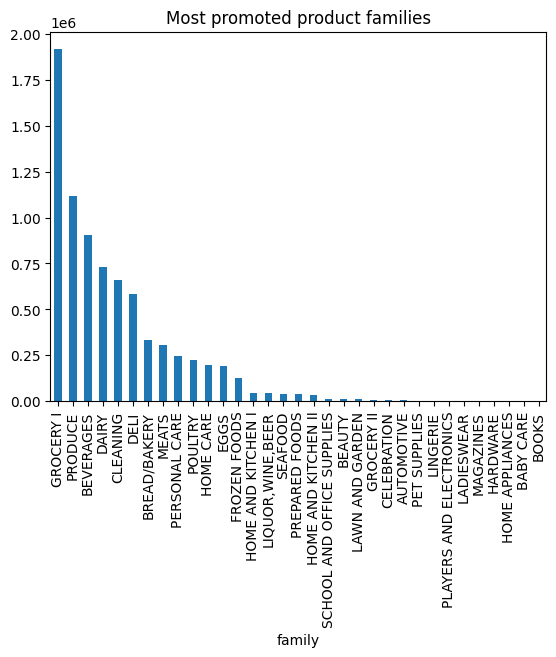

In [30]:
# Most promoted product family?
promoted_families = store_sales.groupby("family")["onpromotion"].sum().sort_values(ascending=False)
promoted_families.plot(kind="bar", title="Most promoted product families");

The plot above shows the most promoted product families sorted in descending order

Observing the plot shows that `GROCERY I` is the most promoted product familiy all time. It's also interesting to see `GRCOERY II` at the lower end of the spectrum.

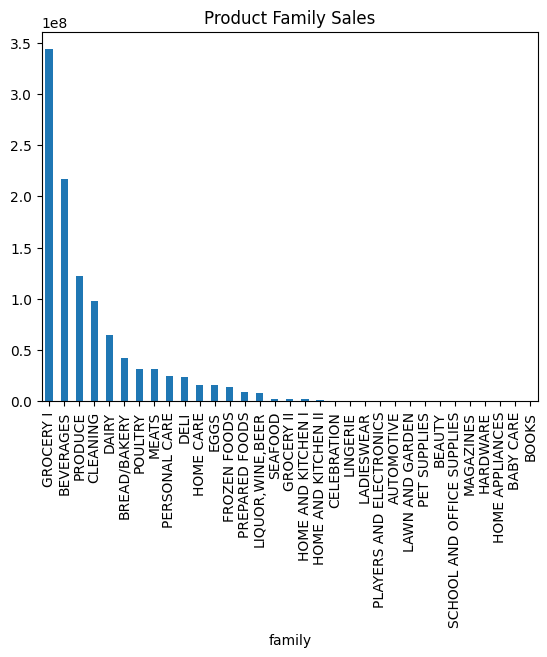

In [31]:
# Product families making the most sales
family_sales = store_sales.groupby("family")["sales"].sum().sort_values(ascending=False)
family_sales.plot(kind="bar", title="Product Family Sales");

The plot above shows the total sales by each product family sorted in descending order

Observing the plot shows that `GROCERY I` still ranks first here, with `GROCERY II` at a similar position and `BOOKS` ranking last. This indicates some correlation. Let's check the correlaction between these two  variables.

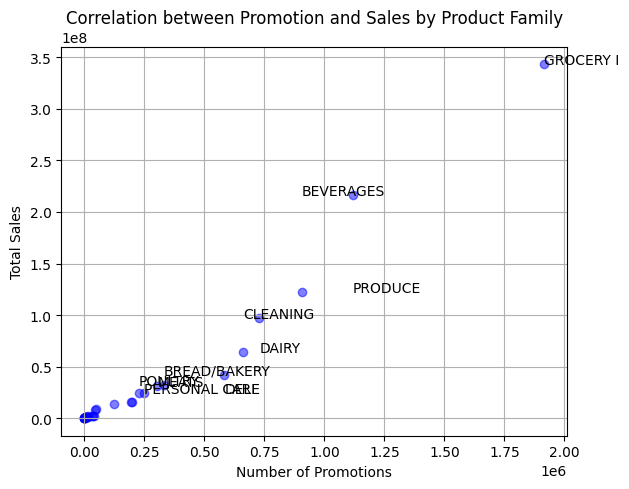

In [32]:
# Create a scatter plot to check correlation
plt.figure(figsize=(6,5))
plt.scatter(promoted_families, family_sales, color='b', alpha=0.5)
plt.title('Correlation between Promotion and Sales by Product Family')
plt.xlabel('Number of Promotions')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()

# annotate top 10 promotions
for family_name in promoted_families[:10].index:
    plt.annotate(family_name, (promoted_families[family_name], family_sales[family_name]))

plt.show()

The correlation plot between Promotion and Sales by Product family is positive. 

One can make an assumption that the amount of promotions is a key factor to how much sales a product family makes at Favorita.

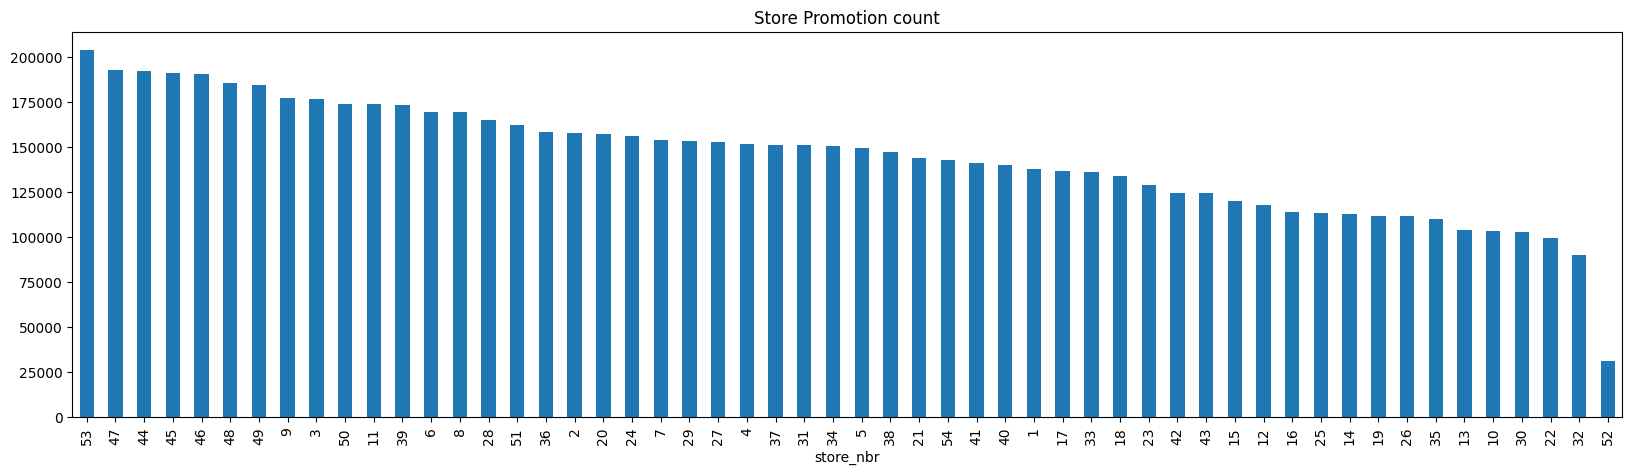

In [33]:
# Most promoted stores
promoted_stores = store_sales.groupby("store_nbr")["onpromotion"].sum().sort_values(ascending=False)
promoted_stores.plot(kind="bar", figsize=(20,5), title="Store Promotion count");

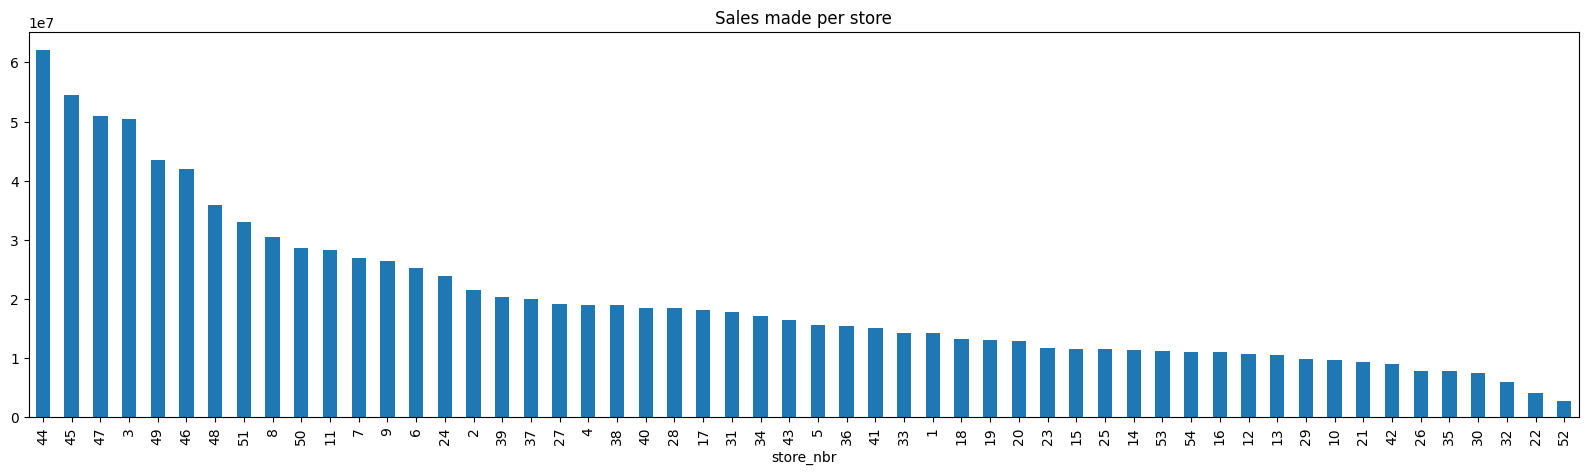

In [34]:
# Sales made by each store
sales_by_store = store_sales.groupby("store_nbr")["sales"].sum().sort_values(ascending=False)
sales_by_store.plot(kind="bar", figsize=(20,5), title="Sales made per store");

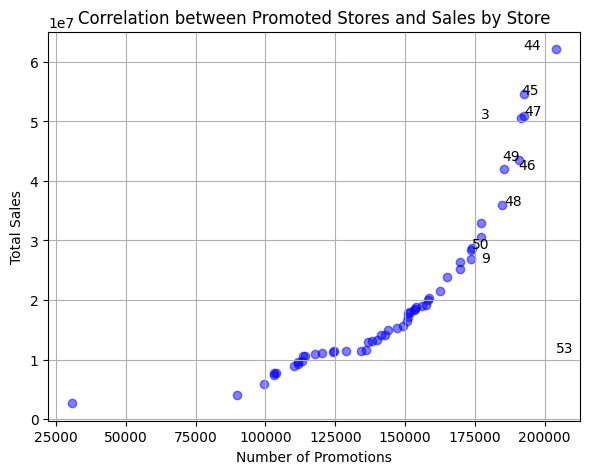

In [35]:
# Create a scatter plot to check correlation
plt.figure(figsize=(6,5))
plt.scatter(promoted_stores, sales_by_store, color='b', alpha=0.5)
plt.title('Correlation between Promoted Stores and Sales by Store')
plt.xlabel('Number of Promotions')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()

# annotate top 10 promotions
for family_name in promoted_stores[:10].index:
    plt.annotate(family_name, (promoted_stores[family_name], sales_by_store[family_name]))

plt.show()

The correlation plot between Promoted Stores and Sales by Store is also positive. 

Like before, one can also make an assumption that the amount of promotions are a key factor to how much sales are made by a Favorita store.

**Store Sales: Data Hierarchy**

The dataset is a time series of the product family sales for each of the favorita stores at every given day.

In [36]:
# rearrange dataset to display it's hierarchical nature
storesales_reindexed = store_sales.groupby(['date', 'store_nbr', 'family']).mean()
storesales_reindexed[:40]

id  sales  onpromotion
date       store_nbr family                                               
2013-01-01 1         AUTOMOTIVE                    0.0    0.0          0.0
                     BABY CARE                     1.0    0.0          0.0
                     BEAUTY                        2.0    0.0          0.0
                     BEVERAGES                     3.0    0.0          0.0
                     BOOKS                         4.0    0.0          0.0
                     BREAD/BAKERY                  5.0    0.0          0.0
                     CELEBRATION                   6.0    0.0          0.0
                     CLEANING                      7.0    0.0          0.0
                     DAIRY                         8.0    0.0          0.0
                     DELI                          9.0    0.0          0.0
                     EGGS                         10.0    0.0          0.0
                     FROZEN FOODS                 11.0    0.0          0.0
                     GROCERY I                    12.0    0.0          0.0
                     GROCERY II                   13.0    0.0          0.0
                     HARDWARE                     14.0    0.0          0.0
                     HOME AND KITCHEN I           15.0    0.0          0.0
                     HOME AND KITCHEN II          16.0    0.0          0.0
                     HOME APPLIANCES              17.0    0.0          0.0
                     HOME CARE                    18.0    0.0          0.0
                     LADIESWEAR                   19.0    0.0          0.0
                     LAWN AND GARDEN              20.0    0.0          0.0
                     LINGERIE                     21.0    0.0          0.0
                     LIQUOR,WINE,BEER             22.0    0.0          0.0
                     MAGAZINES                    23.0    0.0          0.0
                     MEATS                        24.0    0.0          0.0
                     PERSONAL CARE                25.0    0.0          0.0
                     PET SUPPLIES                 26.0    0.0          0.0
                     PLAYERS AND ELECTRONICS      27.0    0.0          0.0
                     POULTRY                      28.0    0.0          0.0
                     PREPARED FOODS               29.0    0.0          0.0
                     PRODUCE                      30.0    0.0          0.0
                     SCHOOL AND OFFICE SUPPLIES   31.0    0.0          0.0
                     SEAFOOD                      32.0    0.0          0.0
           2         AUTOMOTIVE                  363.0    0.0          0.0
                     BABY CARE                   364.0    0.0          0.0
                     BEAUTY                      365.0    0.0          0.0
                     BEVERAGES                   366.0    0.0          0.0
                     BOOKS                       367.0    0.0          0.0
                     BREAD/BAKERY                368.0    0.0          0.0
                     CELEBRATION                 369.0    0.0          0.0

### Analysis on `store_sales`:

**Columns**:
- *store_nbr* - identifies the 54 different stores at which the products are being sold at.
- *family* - identifies the type of products sold (books, automobile, dairy , eggs ,etc..)
- *onpromotion* - shows the total amount of items the were being promoted at a store on a given date in a specific product family.
- *sales (target)* - describes the total sales per product family at a given store on a given date.
  
**Index columns**: 
- date
- store_nbr
- family

**Rows**

* Rows highlight measurement at that "date", in store with "store_nbr", for product family "family"

**Observations**

* there are 3.000.887 rows in total
* there are 33 distinct product families (family) in total, such as AUTOMOTIV, POULTRY
* there are 54 store_nbr in total, ranging over all integers from 1 to 54. They have the same 33 distinct product families
* there are 765 distinct dates in total, ranging from 2013-01-01 to 2017-08-15 (5+ years)
* There is a positive correlation between the Promoted product families and families making the most sales. There is also a positive correlation between the Promoted stores and stores making the most sales. These highlights the promotions has a significant on Favorita's sales.

## 2. `future_sales`

Dataset: **test.csv**

* The test data, having the same features as the training data.
* The dates in the test data are for the 15 days after the last date in the training data (`store_sales`)
* Target sales for the dates are to be predicted.


In [37]:
future_sales = pd.read_csv(
    './data/test.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [38]:
future_sales

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


## 3. `store_metadata`

Dataset: **stores.csv**

Store metadata, including

- *city*, 
- *state*, 
- *type*
- *cluster*: a grouping of similar stores.

In [39]:
store_metadata = pd.read_csv(
    './data/stores.csv',
    dtype=dtype,
)

In [40]:
store_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   store_nbr  54 non-null     int64   
 1   city       54 non-null     category
 2   state      54 non-null     category
 3   type       54 non-null     category
 4   cluster    54 non-null     category
dtypes: category(4), int64(1)
memory usage: 3.0 KB


In [41]:
# Check for missing values
store_metadata.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [42]:
store_metadata.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [43]:
# Number of unique enteries
store_metadata.nunique()

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

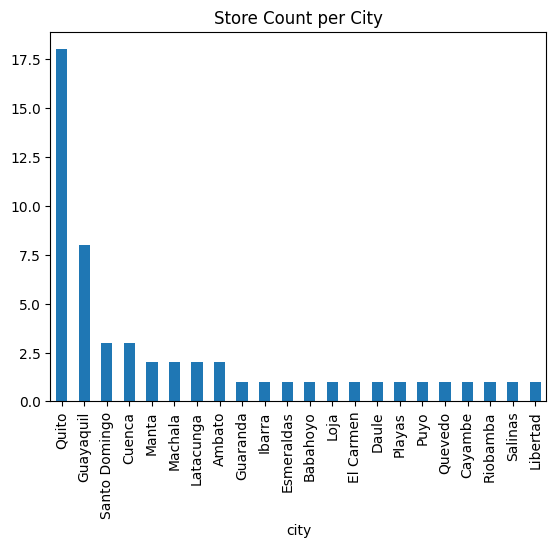

In [44]:
# Number of stores in each city
store_city_count = store_metadata.groupby(['city']).store_nbr.nunique().sort_values(ascending=False)
store_city_count.plot(kind="bar", title="Store Count per City");

The Store Count per city plot shows `Quito` ranks 1st place with a total of 18 stores. 

This is highly reasonable as Quito is the Capital city of Ecuador and according to [Wikipedia](https://en.wikipedia.org/wiki/Ecuador#Largest_cities), is the largest city in the country with 2.78 inhabitants. 

`Guayaquil`, the second largest city with 2.72 million inhabitants appears second in the store count plot with a total of 8 stores. 

Other highly populated cities appear at the high end of the scale and vice-versa

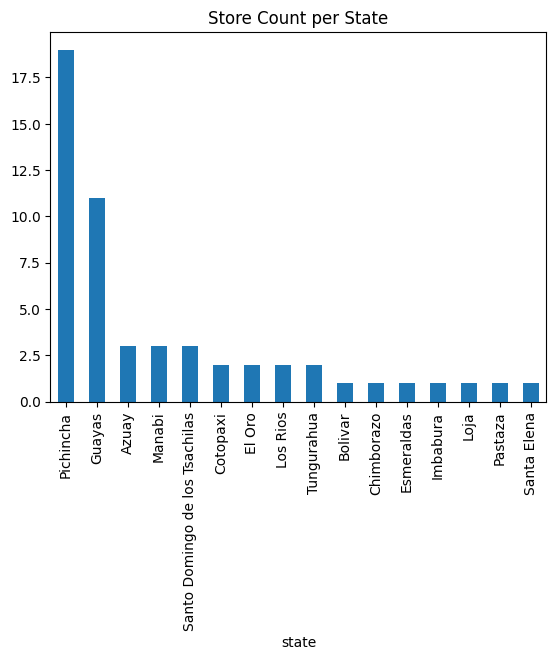

In [46]:
# Number of stores in each state
store_state_count = store_metadata.groupby(['state']).store_nbr.nunique().sort_values(ascending=False)
store_state_count.plot(kind="bar", title="Store Count per State");


Wikipedia mentions `Quito` is also the capital of the Province of `Pichincha` which largely explains it's rank. 

`Guayas` is the Province of `Guayaquil` which also comes second place here.

The overview informs us that `cluster` is a grouping of similar stores

In [442]:
store_metadata.sort_values(by="cluster")

,store_nbr,city,state,type,cluster
26,27,Daule,Guayas,D,1
24,25,Salinas,Santa Elena,D,1
23,24,Guayaquil,Guayas,D,1
42,43,Esmeraldas,Esmeraldas,E,10
35,36,Libertad,Guayas,E,10
30,31,Babahoyo,Los Rios,B,10
28,29,Guayaquil,Guayas,E,10
27,28,Guayaquil,Guayas,E,10
25,26,Guayaquil,Guayas,D,10
51,52,Manta,Manabi,A,11


In [462]:
# View stores in each cluster
store_cluster_items = store_metadata.groupby("cluster").store_nbr.unique()
store_cluster_items

cluster
1                     [24, 25, 27]
10        [26, 28, 29, 31, 36, 43]
11                    [45, 49, 52]
12                            [17]
13                   [1, 2, 6, 53]
14                [46, 47, 48, 50]
15            [10, 12, 13, 15, 19]
16                            [18]
17                            [51]
2                         [37, 42]
3     [16, 30, 32, 33, 35, 40, 54]
4                      [5, 38, 41]
5                             [44]
6          [9, 11, 20, 21, 34, 39]
7                         [14, 22]
8                        [3, 7, 8]
9                          [4, 23]
Name: store_nbr, dtype: object

In [444]:
store_cluster_items[0]

array([44, 45, 46, 47, 48, 49, 50, 51, 52], dtype=int64)

In [463]:
# Examine stores in cluster 1

store_metadata[store_metadata["store_nbr"].isin(store_cluster_items[0])]

,store_nbr,city,state,type,cluster
23,24,Guayaquil,Guayas,D,1
24,25,Salinas,Santa Elena,D,1
26,27,Daule,Guayas,D,1


In [464]:
# Examine sales of stores in cluster n

n=7
cluster_sales = store_sales[store_sales["store_nbr"].isin(store_cluster_items[n])]
cluster_sales

,id,date,store_nbr,family,sales,onpromotion
297,297,2013-01-01,18,AUTOMOTIVE,0.000000,0
298,298,2013-01-01,18,BABY CARE,0.000000,0
299,299,2013-01-01,18,BEAUTY,0.000000,0
300,300,2013-01-01,18,BEVERAGES,0.000000,0
301,301,2013-01-01,18,BOOKS,0.000000,0
...,...,...,...,...,...,...
2999431,2999431,2017-08-15,18,POULTRY,145.542999,0
2999432,2999432,2017-08-15,18,PREPARED FOODS,71.548996,0
2999433,2999433,2017-08-15,18,PRODUCE,3164.251953,155
2999434,2999434,2017-08-15,18,SCHOOL AND OFFICE SUPPLIES,30.000000,7


In [465]:
cluster_sales["sales"].describe()

count    55572.000000
mean       238.598129
std        618.124512
min          0.000000
25%          0.000000
50%          8.000000
75%        147.250496
max      12473.000000
Name: sales, dtype: float64

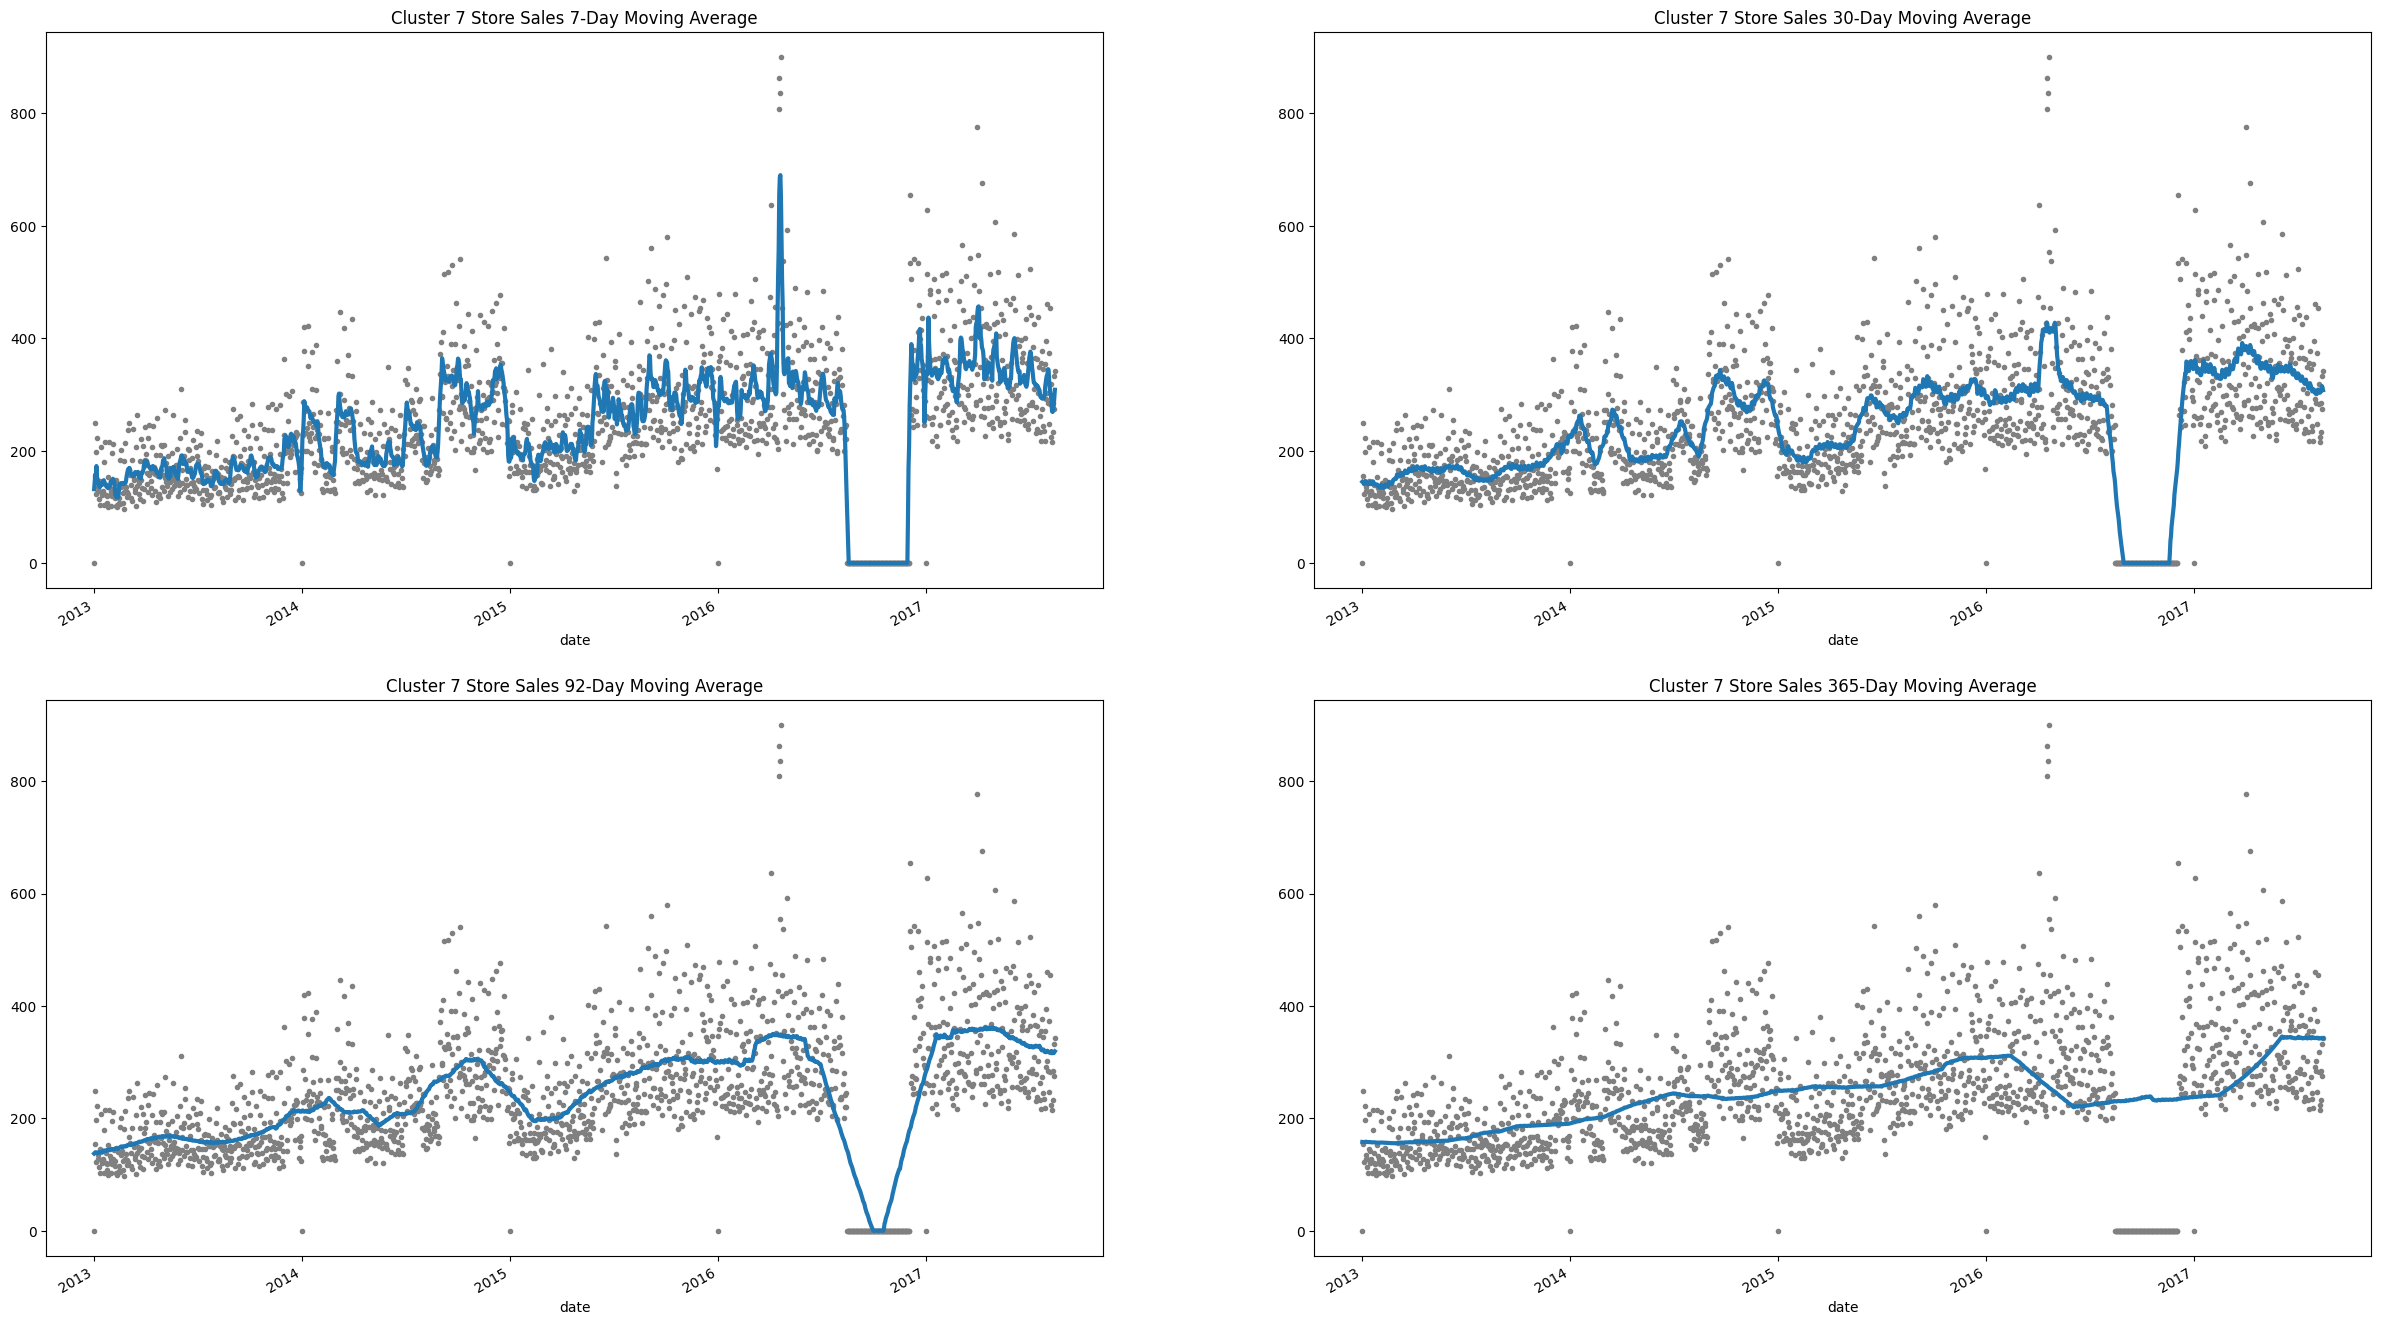

In [469]:
cluster_daily_average_sales = cluster_sales.groupby('date')['sales'].mean()
plot_moving_average(df=cluster_daily_average_sales, title=f"Cluster {n} Store Sales")

Observations

Playing around with the various clusters 

Stores with missing dates are in clusters
Different store clusters have different trends (different line curvatures), perhaps estimators can be trained on different cluster datasets?

e.g. New data comes in -> identify cluster -> do prediction etc.

Maybe do a trend plot for all clusters in a single plot to higlight this. Instead of splitting the moving average into 4.

In [416]:
# store_sales_merged creation is actually done later in this notebook

store_sales_merged.groupby('cluster')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
1,166716.0,326.163971,825.005432,0.0,0.0,15.0,224.294498,35828.000000
10,333432.0,255.897552,731.492798,0.0,0.0,5.0,164.000000,34454.000000
11,166716.0,603.507019,1823.033447,0.0,0.0,5.0,297.902000,76090.000000
12,55572.0,324.461395,852.435181,0.0,0.0,10.0,234.000000,11737.000000
13,222288.0,324.364105,876.439880,0.0,0.0,14.0,216.000000,124717.000000
14,222288.0,708.227722,1804.016235,0.0,3.0,36.0,550.000000,25238.000000
15,277860.0,199.010086,554.876404,0.0,0.0,7.0,136.701252,12669.000000
16,55572.0,238.598129,618.124512,0.0,0.0,8.0,147.250496,12473.000000
17,55572.0,592.231506,1352.209229,0.0,2.0,27.0,386.000000,14179.000000


### Feature Enrichment

Merging more columns to the main `store_sales` dataframe

In [363]:
# dates information
store_sales_merged = store_sales.copy()
store_sales[:1].date.dt.year

0    2013
Name: date, dtype: int32

In [364]:
store_sales_merged["saleYear"] = store_sales_merged.date.dt.year
store_sales_merged["saleMonth"] = store_sales_merged.date.dt.month
store_sales_merged["saleDay"] = store_sales_merged.date.dt.day
store_sales_merged["saleDayOfWeek"] = store_sales_merged.date.dt.dayofweek
store_sales_merged["saleDayOfYear"] = store_sales_merged.date.dt.dayofyear

In [365]:
store_sales_merged.head()

,id,date,store_nbr,family,sales,onpromotion,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,1


In [366]:
# Merge type into store sales dataframe
store_sales_merged = pd.merge(store_sales_merged, store_metadata[['store_nbr', 'type', 'cluster']], on='store_nbr', how='left')

In [367]:
store_sales_merged

,id,date,store_nbr,family,sales,onpromotion,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000000,0,2013,1,1,1,1,D,13
1,1,2013-01-01,1,BABY CARE,0.000000,0,2013,1,1,1,1,D,13
2,2,2013-01-01,1,BEAUTY,0.000000,0,2013,1,1,1,1,D,13
3,3,2013-01-01,1,BEVERAGES,0.000000,0,2013,1,1,1,1,D,13
4,4,2013-01-01,1,BOOKS,0.000000,0,2013,1,1,1,1,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.132996,0,2017,8,15,1,227,B,6
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.552994,1,2017,8,15,1,227,B,6
3000885,3000885,2017-08-15,9,PRODUCE,2419.729004,148,2017,8,15,1,227,B,6
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8,2017,8,15,1,227,B,6


In [1]:
store_sales_merged.to_csv("store_clean.csv")

NameError: name 'store_sales_merged' is not defined

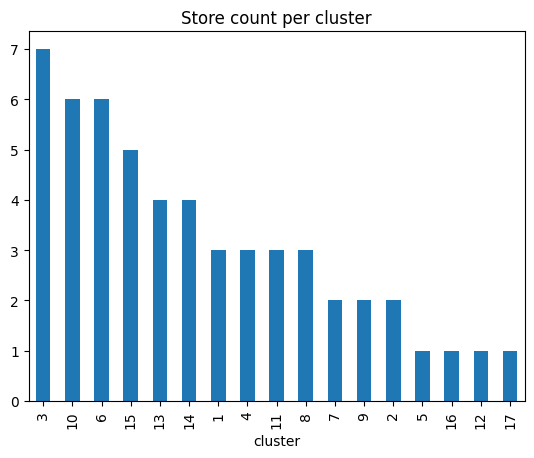

In [960]:
cluster_count = store_metadata.groupby("cluster").store_nbr.nunique().sort_values(ascending=False)
cluster_count.plot(kind="bar", title="Store count per cluster");

In [961]:
store_metadata.groupby("cluster").store_nbr.unique()

cluster
1                     [24, 25, 27]
10        [26, 28, 29, 31, 36, 43]
11                    [45, 49, 52]
12                            [17]
13                   [1, 2, 6, 53]
14                [46, 47, 48, 50]
15            [10, 12, 13, 15, 19]
16                            [18]
17                            [51]
2                         [37, 42]
3     [16, 30, 32, 33, 35, 40, 54]
4                      [5, 38, 41]
5                             [44]
6          [9, 11, 20, 21, 34, 39]
7                         [14, 22]
8                        [3, 7, 8]
9                          [4, 23]
Name: store_nbr, dtype: object

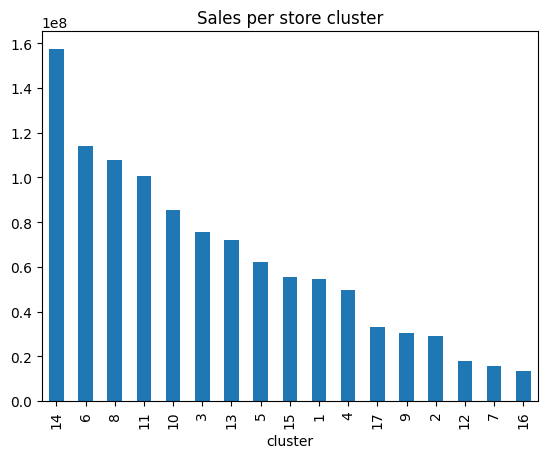

In [962]:
# Sales made by each store cluster
store_cluster_sales = store_sales_merged.groupby(["cluster"])['sales'].sum().sort_values(ascending=False)
store_cluster_sales.plot(kind="bar", title="Sales per store cluster");

In [963]:
# Use this to group cluster plot by most sales
store_clustersales_index = [i for i in store_cluster_sales.index]
store_clustersales_index

['14',
 '6',
 '8',
 '11',
 '10',
 '3',
 '13',
 '5',
 '15',
 '1',
 '4',
 '17',
 '9',
 '2',
 '12',
 '7',
 '16']

## 4. `holidays_events` 

Dataset: **holidays_events.csv**

Holidays and Events, with metadata.

NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [17]:
holidays_events = pd.read_csv(
    './data/holidays_events.csv',
    dtype=dtype,
    parse_dates=['date']
)

## 5. `transactions`: 

Notes: Separate for now

In [913]:
transactions = pd.read_csv(
    './data/transactions.csv',
    dtype=dtype,
    parse_dates=['date']
)

In [914]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


## 6. `daily_oil_price`

Dataset: **oil.csv**

Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

* Includes daily oil price. 
* Includes values during both the train and test data timeframes.

Notes: Can be used later as exogenous

In [12]:
daily_oil_price = pd.read_csv(
    './data/oil.csv',
    dtype=dtype,
    parse_dates=['date']
)

# daily_oil_price.info()

# TREND

Let's Examine the Trend in Favorita store sales by answering the following questions.

1. Total store sales strend
2. Product families' sales trend
3. Total transactions trend

In [221]:
# Function for moving average plot
def plot_moving_average(df, plot_df=None, title="N/A", windows=None, axes=None, remove_legend=False, legend_loc=None):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,
                                             ncols=2,
                                             figsize=(30,18))

    if windows is None:
      windows = [7, 30, 92, 365]
    
    if axes is None:
      axes =[ax1, ax2, ax3, ax4]

    if plot_df is None:
          plot_df = df

    for window, ax in zip(windows, axes):
      moving_average = df.rolling(
          window=window,
          center=True,
          min_periods=window//2
      ).mean()

      plot_df.plot(style=".", color="0.5", ax=ax)
      moving_average.plot(
          ax=ax, linewidth=3, title=f"{title} {window}-Day Moving Average", legend=False
      )

      if remove_legend:
        try:
          ax.get_legend().remove()
        except:
          pass

    # Use a single Legend
    if legend_loc:
      handles, labels = axes[-1].get_legend_handles_labels()
      fig.legend(handles, labels, loc=legend_loc);

In [222]:
# 1. Average sales Favorita makes each day
daily_average_sales = store_sales.groupby('date')['sales'].mean()
daily_average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
                 ...    
2017-08-11    463.733856
2017-08-12    444.798309
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Name: sales, Length: 1684, dtype: float32

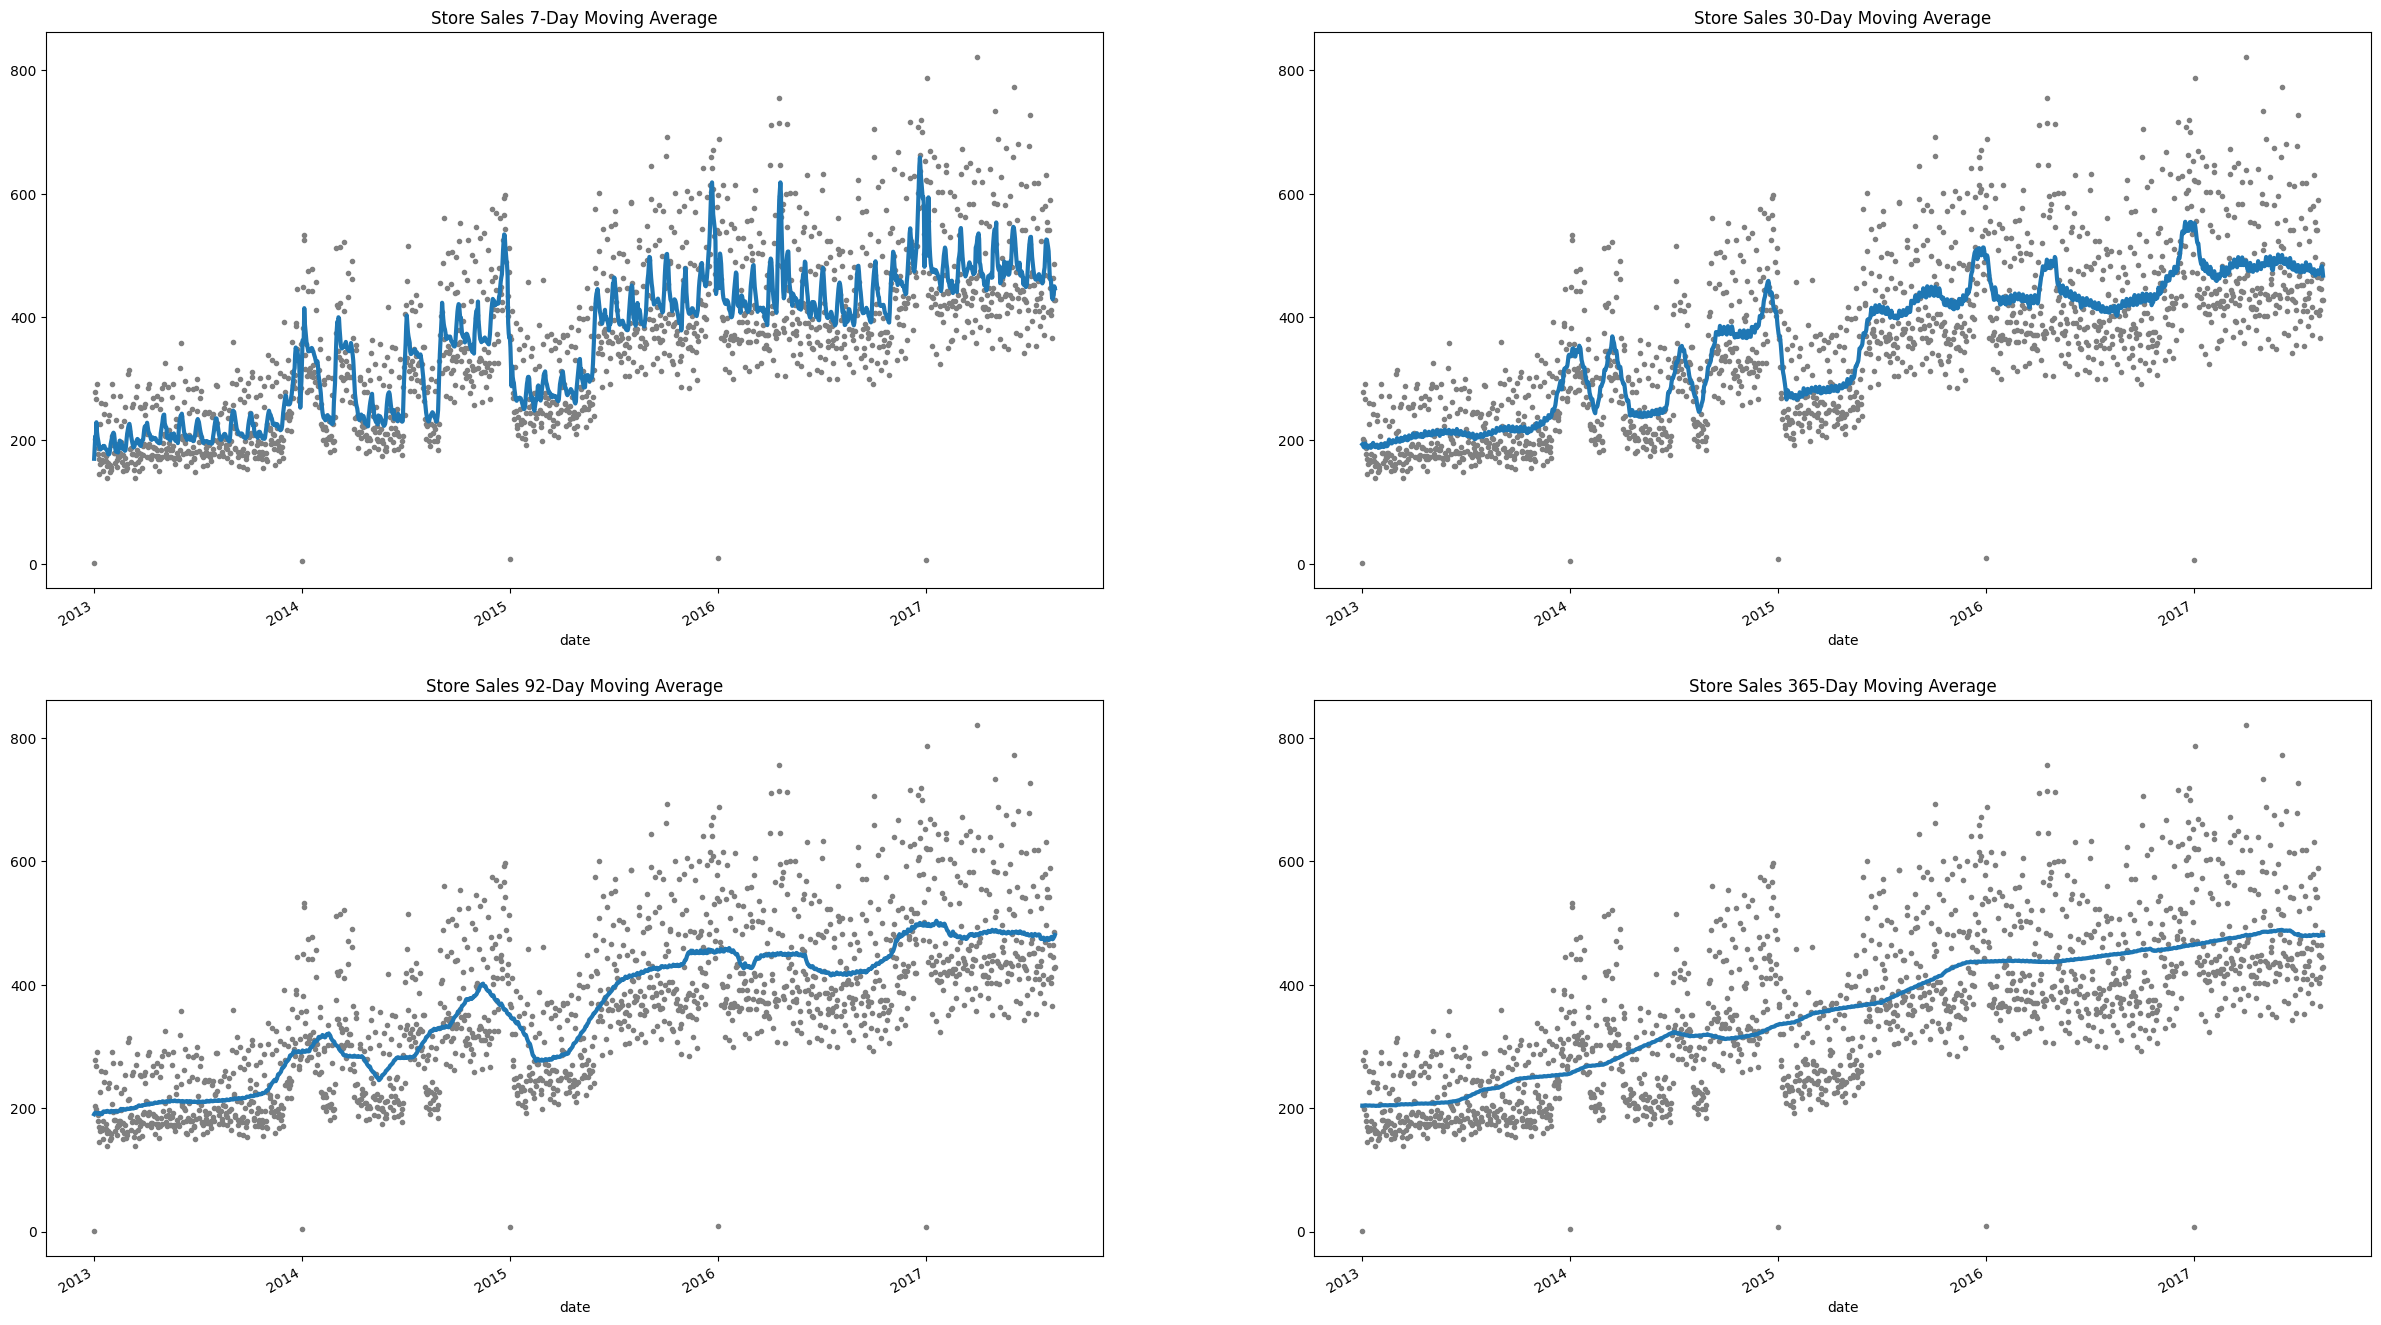

In [223]:
# Let's see the trend
plot_moving_average(df=daily_average_sales, title="Store Sales")

##2. Average sales each product family brings to Favorita each day


Favorita stores has 33 product families.
* What's the sales trend for each product family?

In [224]:
store_sales.groupby(['date', 'store_nbr'])['sales'].mean()

date        store_nbr
2013-01-01  1              0.000000
            2              0.000000
            3              0.000000
            4              0.000000
            5              0.000000
                            ...    
2017-08-15  50           511.488525
            51           610.744202
            52           563.637695
            53           248.733017
            54           383.844177
Name: sales, Length: 90936, dtype: float32

In [225]:
# Group by 'date' and 'family', calculate mean sales
daily_avg_family_sales = store_sales.groupby(['date', 'family'])['sales'].mean().reset_index()

# Pivot the data for easier plotting (date as index, family as columns)
pivot_df = daily_avg_family_sales.pivot(index='date', columns='family', values='sales')
pivot_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.0,0.037037,15.000000,0.0,3.344241,0.0,3.444444,2.648148,1.316481,...,0.0,2.051870,0.462963,0.0,0.0,0.789574,0.700870,0.0,0.0,0.000000
2013-01-02,4.722222,0.0,3.833333,1335.036987,0.0,486.042938,0.0,1382.018555,432.981476,291.750000,...,0.0,386.508606,318.592590,0.0,0.0,258.812683,98.853935,0.0,0.0,28.273148
2013-01-03,2.981482,0.0,2.314815,964.907410,0.0,341.786682,0.0,1035.055542,333.351837,206.897324,...,0.0,307.359222,232.740738,0.0,0.0,197.673965,66.507187,0.0,0.0,20.265018
2013-01-04,3.129630,0.0,2.462963,1003.092590,0.0,309.666077,0.0,964.148132,336.074066,187.837204,...,0.0,400.480804,209.314819,0.0,0.0,199.491013,82.832703,0.0,0.0,23.946684
2013-01-05,6.333333,0.0,3.537037,1441.074097,0.0,414.217804,0.0,1298.666626,427.444458,254.350845,...,0.0,386.649841,311.462952,0.0,0.0,249.537201,107.964317,0.0,0.0,23.067350


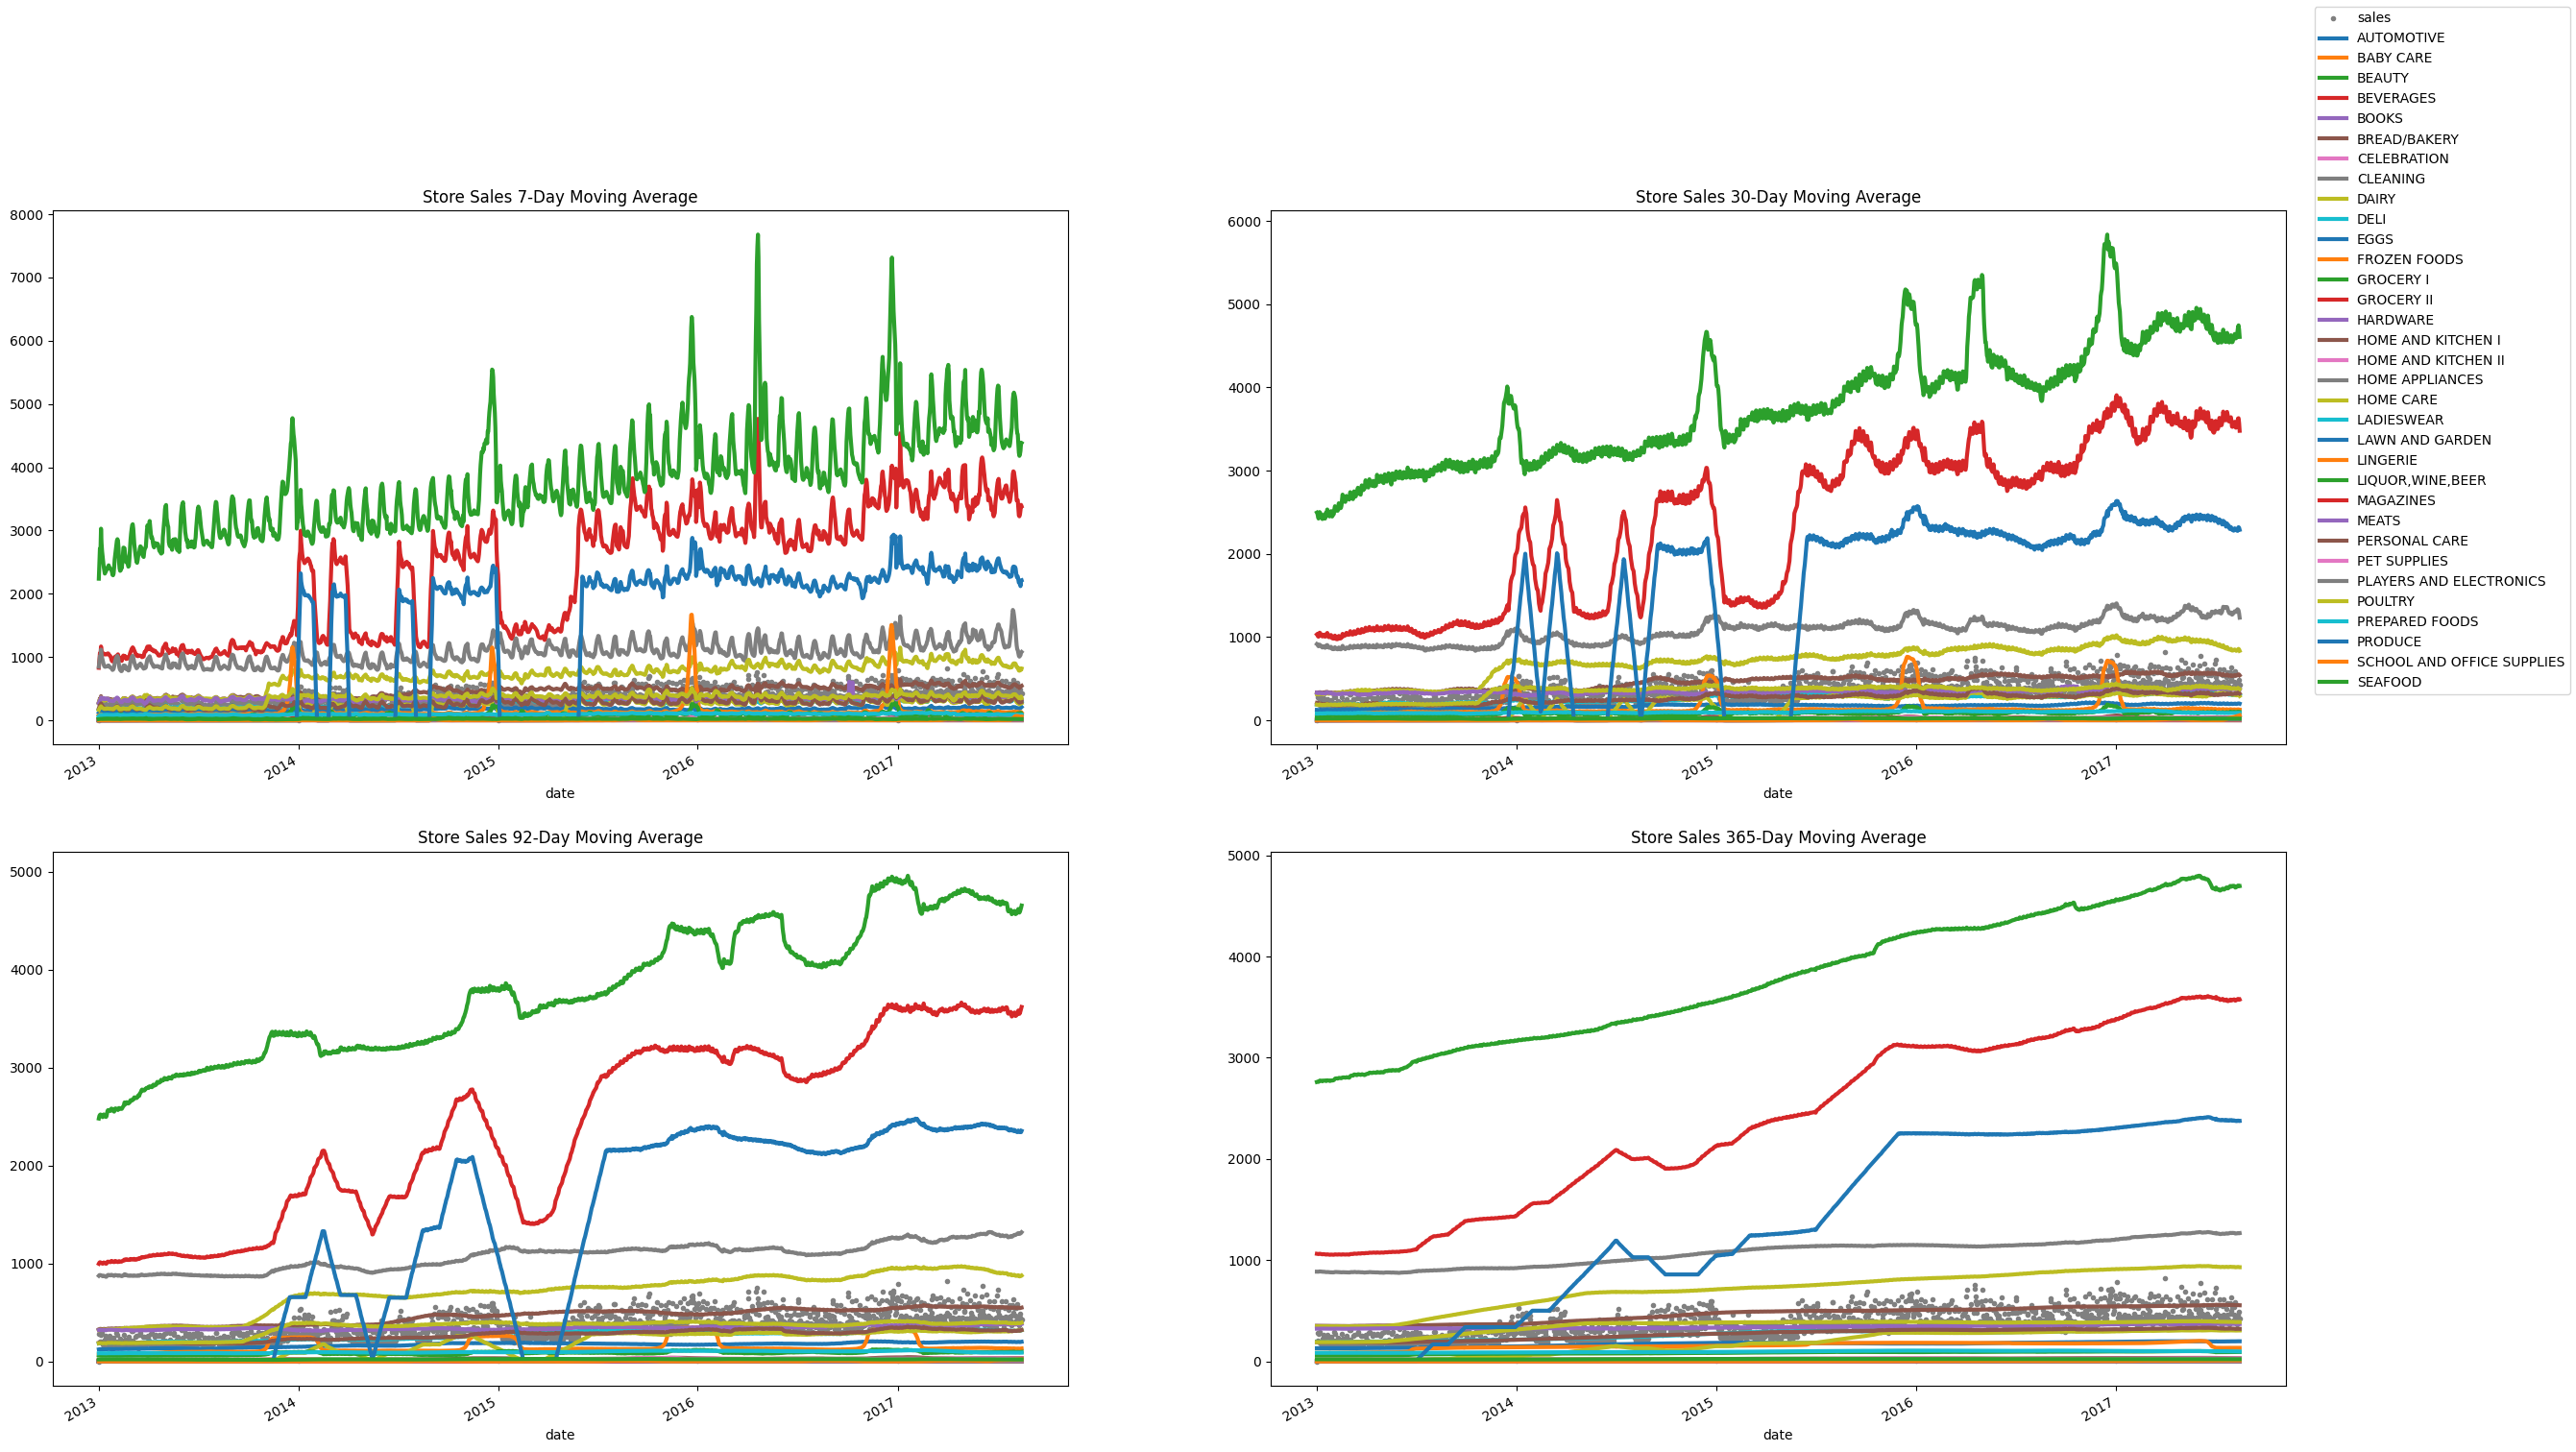

In [226]:
plot_moving_average(df=pivot_df, plot_df=daily_average_sales, title="Store Sales", legend_loc="upper right")

In [227]:
transactions

NameError: name 'transactions' is not defined

In [ ]:
plot_moving_average(
    df=transactions.groupby('date')['transactions'].mean(),
    title="transactions",
    )

### Product families with highest sales values.

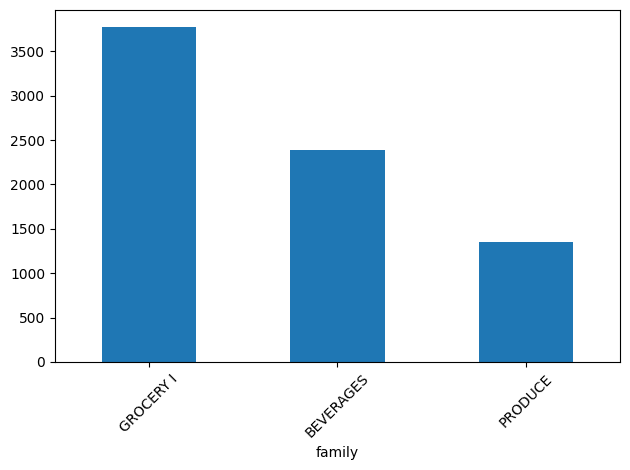

In [140]:
# Group by product 'family' and calculate the average sales
avg_sales = store_sales.groupby('family')['sales'].mean().sort_values(ascending=False)

# Take the top n product families
n = 3
top_families = avg_sales.head(n)

#  Plottinh
top_families.plot(kind="bar")
plt.xticks(rotation=45)
plt.tight_layout()  # Ensures all labels fit within the figure area
plt.show()

View the Top families sales trend

In [141]:
pivot_df_filtered = pivot_df[top_families.index]

# Calculate daily average sales for the top families
daily_avg_sales_top_families = pivot_df_filtered.mean(axis=1)
daily_avg_sales_top_families

date
2013-01-01       9.320988
2013-01-02    1692.049316
2013-01-03    1215.944458
2013-01-04    1172.351807
2013-01-05    1643.049316
                 ...     
2017-08-11    3370.809326
2017-08-12    3288.481445
2017-08-13    3621.729736
2017-08-14    3181.760986
2017-08-15    3210.432617
Length: 1684, dtype: float32

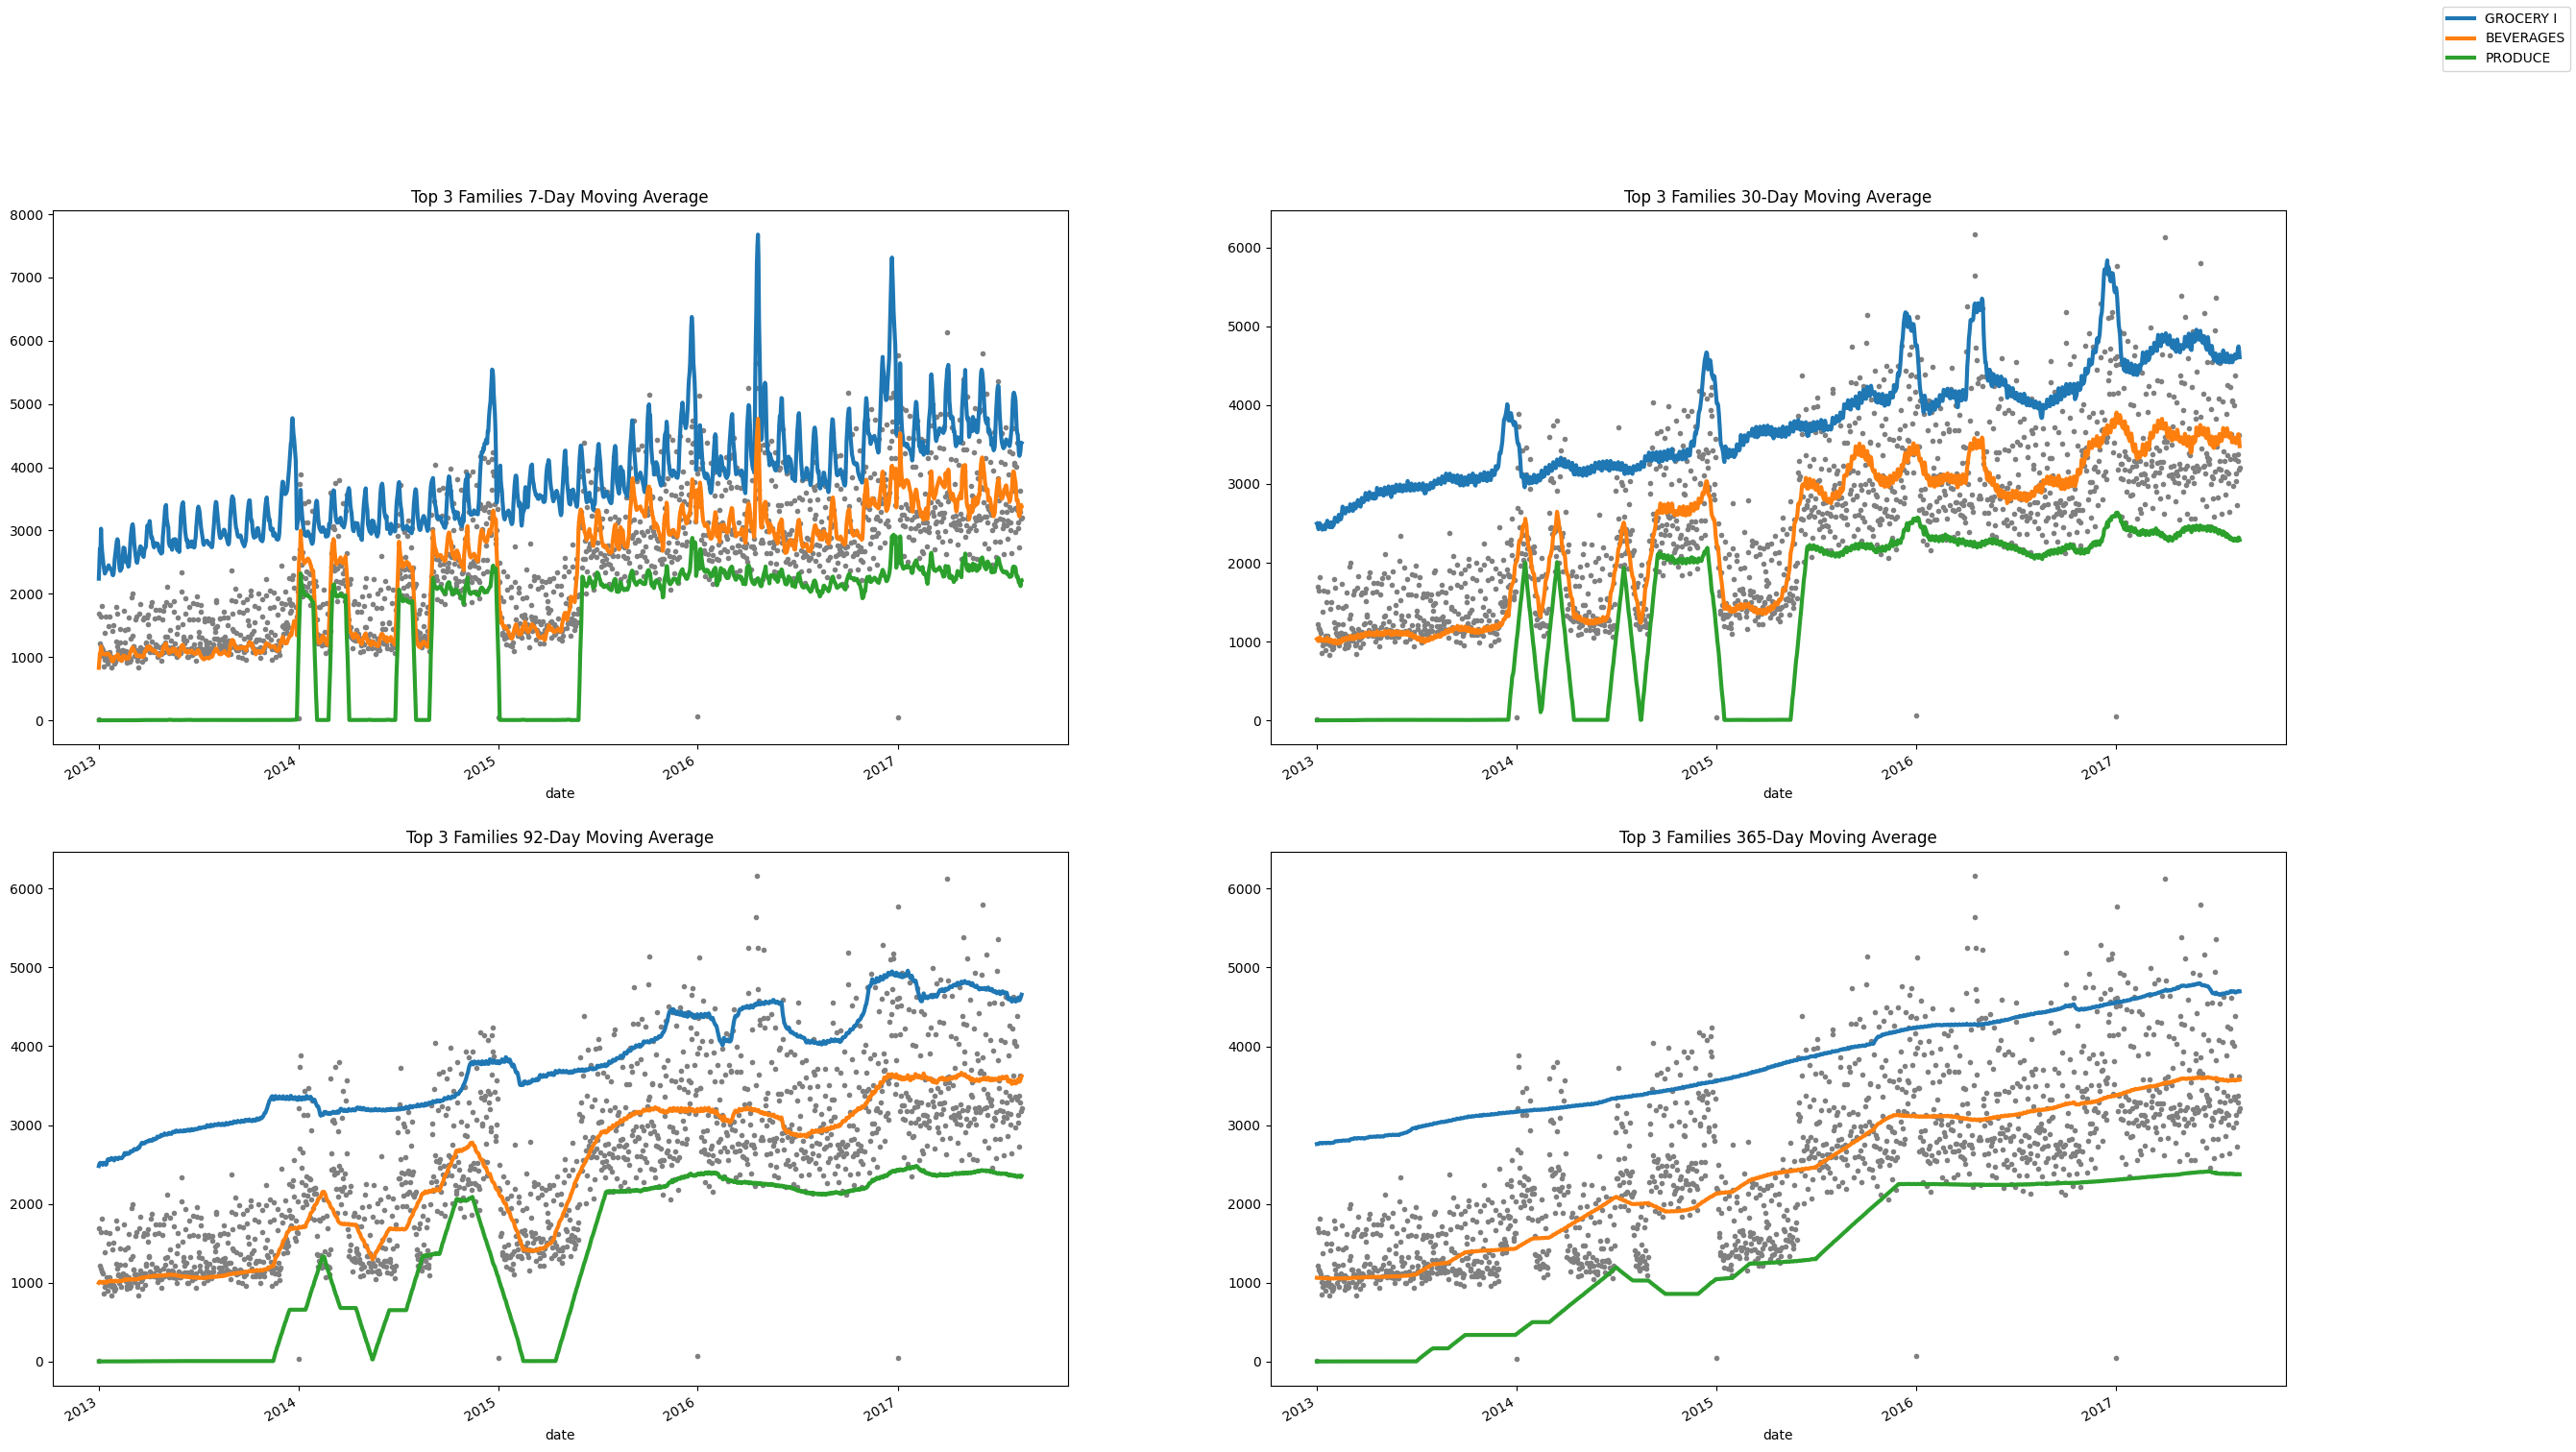

In [142]:
plot_moving_average(
    pivot_df_filtered, 
    title=f"Top {n} Families",
    plot_df= daily_avg_sales_top_families, legend_loc="upper right")

how many stores? how many product groups?
coverage in terms of start/end of record per store
summary of sales by store, do statistical summaries on the summaries. E.g., average sales in a year, variation, etc.
there are marked "jumps" in the mean aggregate over stores. What explains these? Could be artefact start/end
similar analysis for product groups
interaction analysis product groups and stores. Which stores sell which products? How does the product compositiòn distribute?